<a href="https://colab.research.google.com/github/Evlog01/Defining-the-types-of-quests-in-games/blob/main/GitHub_Practical_work_%E2%84%96_1%2C_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача 3. Творческая
Во многих крупных ИТ-компаниях существует практика, что сотрудник 80% времени тратит на проекты компании, а 20% на проекты, которые, как он считает могут принести прибыль компании в будущем. Умение вести такие "личные" проекты - очень высоко ценится.

Твоя  задача, поставить такую задачу перед собой и ее решить, используя следующие вводные:

Это должна быть задача классического машинного обучения.
Ты должен продемонстрировать умение визуализировать данные.
Твое решение должно быть полным, работоспособным, с развернутым описанием.
Твоя задача не должна быть заимствована с GitHub, Kaggle, Хабра и т.д.
Использовать можно любой публичный датасет.
Если ты знаешь, где хочешь работать, то попробуй спрогнозировать, какая задача будет в будущем интересна для этой компании.
Если у тебя имеется своя личная задача, которую ты хочешь решить в рамках курса или с которой ты пришел на курс, можешь взять ее.

Gодробное описание квестов в датасете (https://huggingface.co/datasets/dprashar/npc_dialogue_rpg_quests) , позволило провести анализ на выявление типов квестов (что нужно делать игроку) по содержанию текстов квестов (заданий).

*   Истинные метрики были созданы самостоятельно и могут быть изменены.

*   Количества квестов типа "other" говорит о том, что можно добавить большее количество типов квестов.

In [ ]:
# Загрузка данных
!wget https://huggingface.co/datasets/dprashar/npc_dialogue_rpg_quests/resolve/main/output.json

--2025-08-03 11:20:29--  https://huggingface.co/datasets/dprashar/npc_dialogue_rpg_quests/resolve/main/output.json
Resolving huggingface.co (huggingface.co)... 3.165.160.61, 3.165.160.12, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.61|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a8/55/a8552ed1fe2b65d180fd705e77a7f74446350314cab5015cfb104bde19a67ffa/f99735aebeb0f4fcc3ad02b7a05db49daeaa4693bd781f30341e9d67ebe46734?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27output.json%3B+filename%3D%22output.json%22%3B&response-content-type=application%2Fjson&Expires=1754223629&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1NDIyMzYyOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2E4LzU1L2E4NTUyZWQxZmUyYjY1ZDE4MGZkNzA1ZTc3YTdmNzQ0NDYzNTAzMTRjYWI1MDE1Y2ZiMTA0YmRlMTlhNjdmZmEvZjk5NzM1YWViZWIwZjRmY2MzYWQwMmI3YTA1ZGI0OWRhZWFhNDY5M2JkNzg

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

In [ ]:
with open('output.json', 'r') as f:
    data = json.load(f)

# Преобразование в DataFrame
df = pd.DataFrame(data)
print(f"Загружено {len(df)} записей")

Загружено 24840 записей


In [ ]:
# Анализ данных
print("Информация о датасете:")
print(df.info())
print("\nПервые 5 записей:")
print(df.head())
print("\nСтатистика по колонкам:")
print(df.describe(include='object'))

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24840 entries, 0 to 24839
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      24840 non-null  object
 1   Objective  24840 non-null  object
 2   Text       24840 non-null  object
dtypes: object(3)
memory usage: 582.3+ KB
None

Первые 5 записей:
                      Title  \
0         A Lesson to Learn   
1         Kanrethad's Quest   
2      Rise of the Silithid   
3  Wolves Across the Border   
4              Aquatic Form   

                                           Objective  \
0  Speak with Dendrite Starblaze in the village o...   
1  Speak to Kanrethad to restore your talents, we...   
2  Take the report to Zilzibin Drumlore in Orgrim...   
3  Bring 8 Diseased Wolf Pelts to Eagan Peltskinn...   
4  Return to Thunder Bluff and show Turak Runetot...   

                                                Text  
0  , I have been following yo

In [ ]:
# Создание метки на основе ключевых слов
def detect_quest_type(text):
    text = text.lower()
    if 'collect' in text or 'gather' in text:
        return 'collection'
    elif 'deliver' in text or 'bring' in text:
        return 'delivery'
    elif 'kill' in text or 'defeat' in text or 'eliminate' in text:
        return 'combat'
    elif 'find' in text or 'locate' in text:
        return 'exploration'
    elif 'talk' in text or 'speak' in text:
        return 'dialogue'
    else:
        return 'other'


df['quest_type'] = df['Objective'].apply(detect_quest_type)

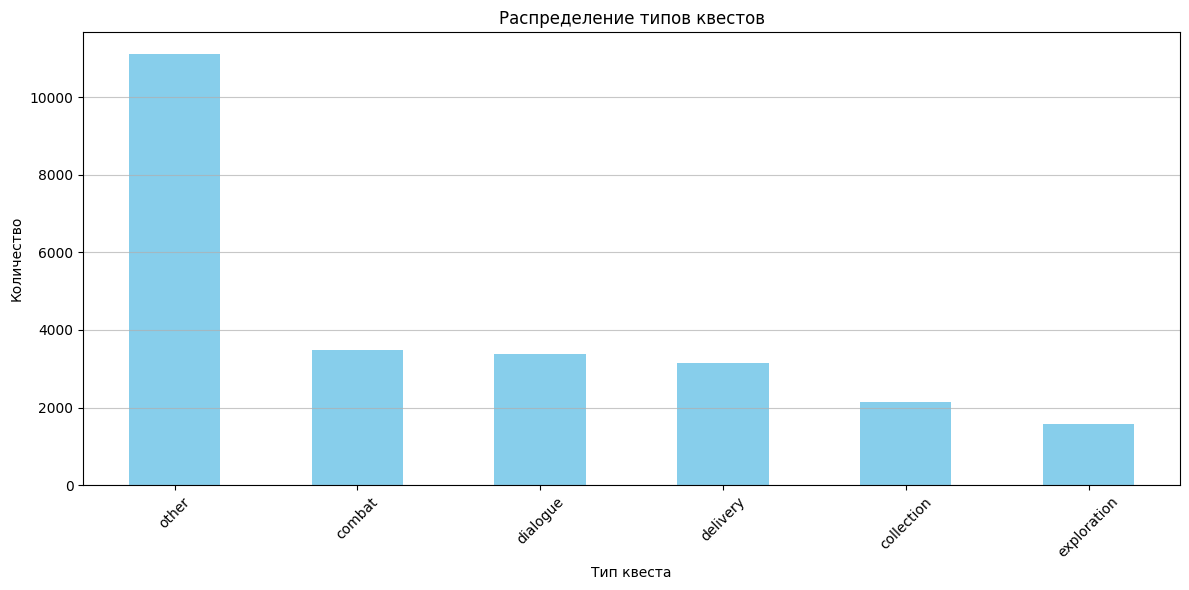

In [ ]:
# Визуализация распределения типов квестов
plt.figure(figsize = (12, 6))
df['quest_type'].value_counts().plot(kind = 'bar', color = 'skyblue')
plt.title('Распределение типов квестов')
plt.xlabel('Тип квеста')
plt.ylabel('Количество')
plt.xticks(rotation = 45)
plt.grid(axis = 'y', alpha = 0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Объединение текстовых данных для анализа
df['combined_text'] = df['Title'] + ' ' + df['Objective'] + ' ' + df['Text']

In [ ]:
# Очистка текста
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\[.*?\]', '', text)   # Удаление тегов
    text = re.sub(r'\W', ' ', text)       # Удаление спецсимволов
    text = re.sub(r'\d+', '', text)       # Удаление цифр
    text = text.lower()                   # Приведение к нижнему регистру
    text = re.sub(r'\s+', ' ', text)      # Удаление лишних пробелов
    return text.strip()

df['cleaned_text'] = df['combined_text'].apply(clean_text)

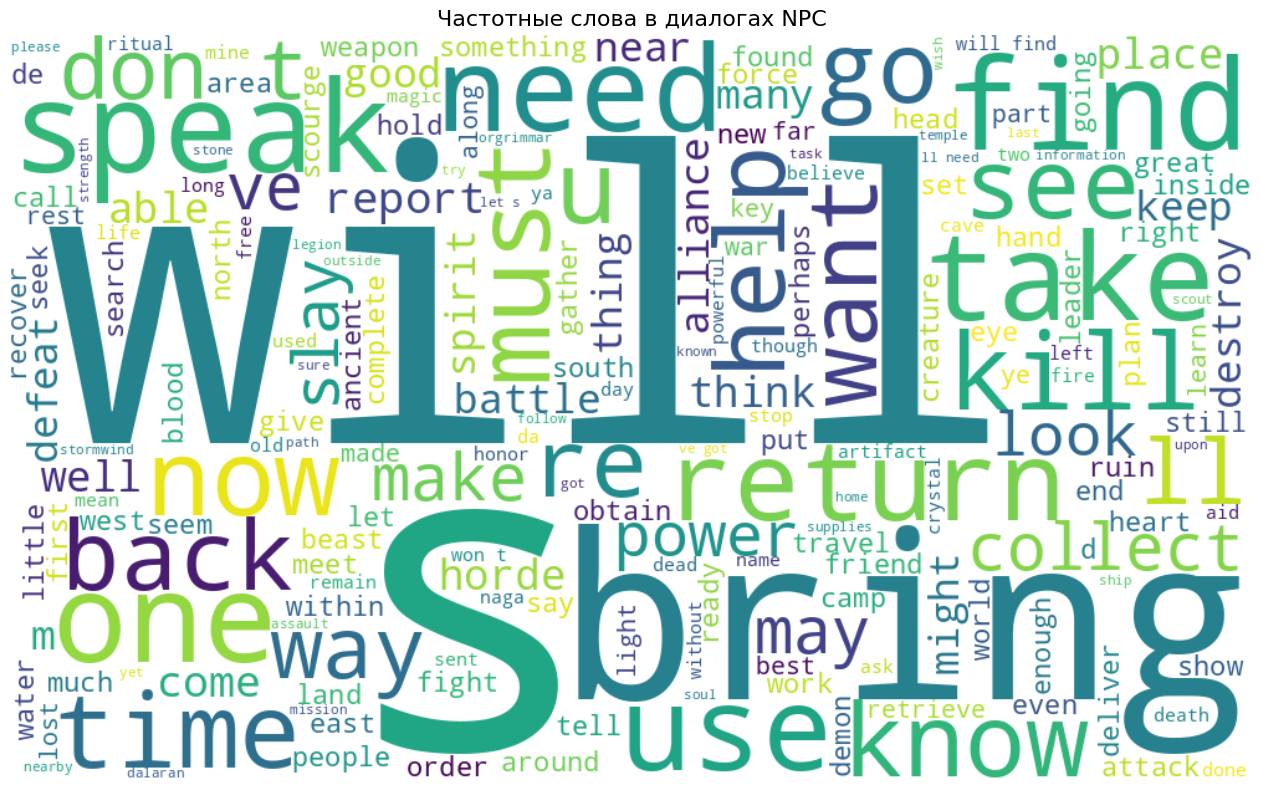

In [ ]:
# Визуализация данных
all_text = " ".join(df['cleaned_text'])
wordcloud = WordCloud(width = 1000, height = 600, background_color = 'white', max_words = 200, colormap = 'viridis').generate(all_text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Частотные слова в диалогах NPC', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Векторизация текста
vectorizer = TfidfVectorizer(max_features = 3000, stop_words = 'english', ngram_range = (1, 2), min_df = 5)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['quest_type']
print(f"\nКоличество признаков после векторизации: {X.shape[1]}")


Количество признаков после векторизации: 3000


In [ ]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
print(f"\nРазмеры данных:")
print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")


Размеры данных:
Обучающая выборка: 18630 записей
Тестовая выборка: 6210 записей


In [ ]:
# Обучение модели
model = RandomForestClassifier(
    n_estimators = 150,
    max_depth = 20,
    min_samples_split = 5,
    random_state = 42,
    class_weight = 'balanced',
    n_jobs = -1)

print("\nОбучение модели")
model.fit(X_train, y_train)



Обучение модели


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=5, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [ ]:
# Оценка модели
y_pred = model.predict(X_test)
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))


Отчет о классификации:
              precision    recall  f1-score   support

  collection       0.86      0.94      0.90       538
      combat       0.82      0.93      0.87       868
    delivery       0.72      0.94      0.81       788
    dialogue       0.83      0.96      0.89       843
 exploration       0.40      0.44      0.42       394
       other       0.91      0.72      0.80      2779

    accuracy                           0.81      6210
   macro avg       0.76      0.82      0.78      6210
weighted avg       0.82      0.81      0.81      6210



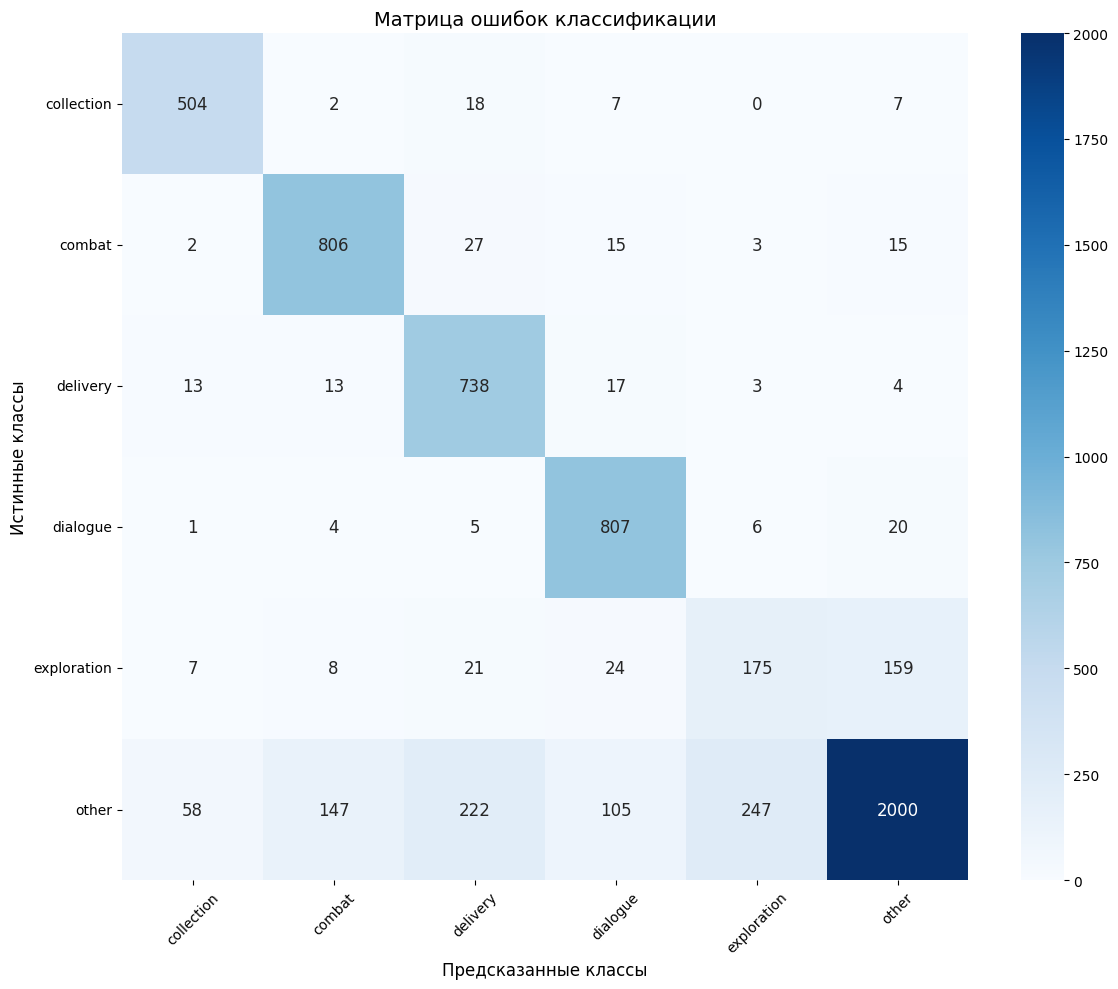

In [ ]:
# Матрица ошибок
plt.figure(figsize = (12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = model.classes_,
            yticklabels = model.classes_,
            annot_kws = {"size": 12})
plt.title('Матрица ошибок классификации', fontsize = 14)
plt.xlabel('Предсказанные классы', fontsize = 12)
plt.ylabel('Истинные классы', fontsize = 12)
plt.xticks(fontsize = 10, rotation = 45)
plt.yticks(fontsize = 10, rotation = 0)
plt.tight_layout()
plt.show()

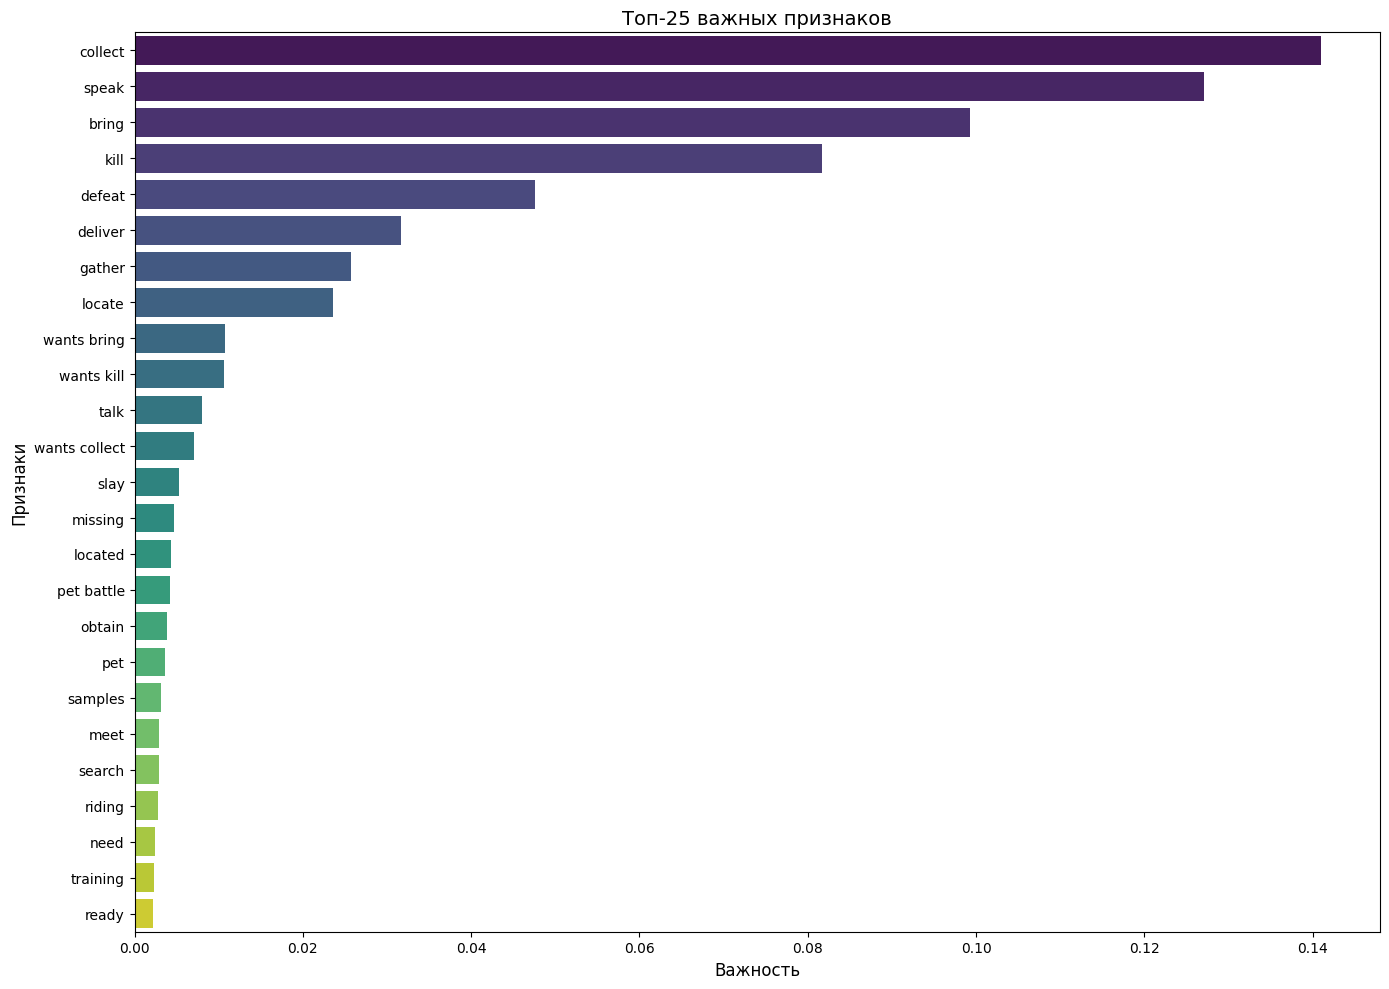

In [ ]:
# Важные признаки
feature_names = vectorizer.get_feature_names_out()
importances = model.feature_importances_
top_n = 25
top_indices = importances.argsort()[-top_n:][::-1]

plt.figure(figsize = (14, 10))
sns.barplot(x = importances[top_indices], y = feature_names[top_indices],  hue = feature_names[top_indices], palette = 'viridis', legend = False)
plt.title(f'Топ-{top_n} важных признаков', fontsize = 14)
plt.xlabel('Важность', fontsize = 12)
plt.ylabel('Признаки', fontsize = 12)
plt.tight_layout()
plt.show()

In [ ]:
test_samples = [
    "Collect 10 wolf pelts for the blacksmith",
    "Deliver this sealed letter to the king in the capital city",
    "Defeat the dragon terrorizing the village",
    "Find the ancient artifact hidden in the ruins",
    "Speak with the elder to learn about our history"]

print("\nПримеры предсказаний:")
for text in test_samples:
    # Очищаем текст
    cleaned = clean_text(text)
    # Преобразуем в вектор
    vector = vectorizer.transform([cleaned])
    # Получаем предсказание
    pred = model.predict(vector)[0]
    probs = model.predict_proba(vector)[0]

    print(f"\nТекст: '{text}'")
    print(f"Предсказанный тип квеста: {pred}")
    print("Вероятности по классам:")
    for i in range(len(model.classes_)):
        cls = model.classes_[i]
        prob = probs[i]
        print(f"  {cls}: {prob:.4f}")


Примеры предсказаний:

Текст: 'Collect 10 wolf pelts for the blacksmith'
Предсказанный тип квеста: collection
Вероятности по классам:
  collection: 0.4216
  combat: 0.1007
  delivery: 0.1016
  dialogue: 0.0964
  exploration: 0.1326
  other: 0.1471

Текст: 'Deliver this sealed letter to the king in the capital city'
Предсказанный тип квеста: delivery
Вероятности по классам:
  collection: 0.0894
  combat: 0.1003
  delivery: 0.4226
  dialogue: 0.0957
  exploration: 0.1283
  other: 0.1637

Текст: 'Defeat the dragon terrorizing the village'
Предсказанный тип квеста: combat
Вероятности по классам:
  collection: 0.0969
  combat: 0.3628
  delivery: 0.0972
  dialogue: 0.1215
  exploration: 0.1481
  other: 0.1734

Текст: 'Find the ancient artifact hidden in the ruins'
Предсказанный тип квеста: other
Вероятности по классам:
  collection: 0.1276
  combat: 0.1430
  delivery: 0.1265
  dialogue: 0.1411
  exploration: 0.2151
  other: 0.2467

Текст: 'Speak with the elder to learn about our history'
Пр

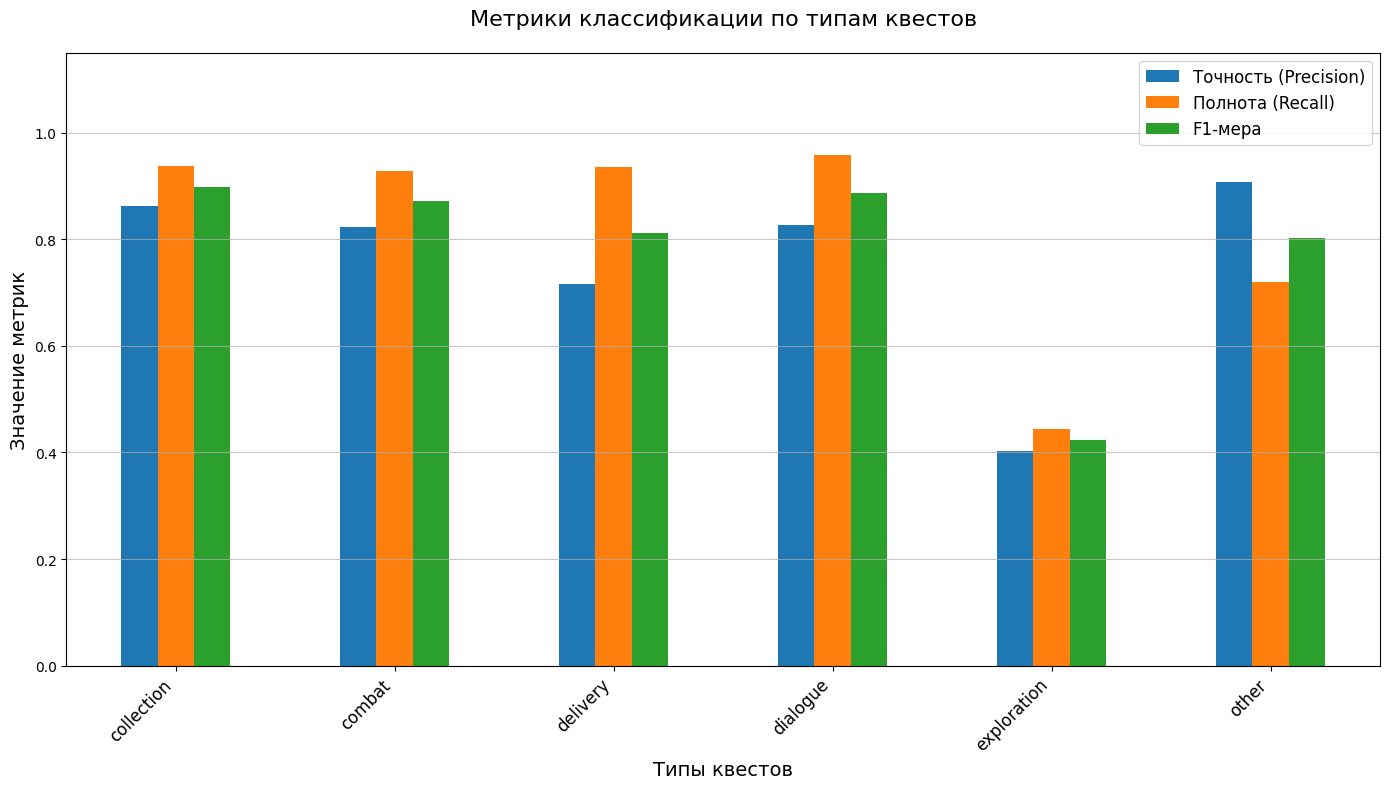

In [ ]:
# Анализ распределения классов
class_report = classification_report(y_test, y_pred, output_dict = True)
class_metrics = pd.DataFrame(class_report).transpose()

ax = class_metrics[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind = 'bar', figsize = (14, 8))

plt.title('Метрики классификации по типам квестов', fontsize = 16, pad = 20)
plt.xlabel('Типы квестов', fontsize = 14)
plt.ylabel('Значение метрик', fontsize = 14)

plt.xticks(rotation = 45, ha = 'right', fontsize = 12)
plt.ylim(0, 1.15)
plt.legend(['Точность (Precision)', 'Полнота (Recall)', 'F1-мера'], fontsize = 12, loc = 'upper right')
plt.grid(axis = 'y', alpha = 0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Сохранение результатов
results_df = pd.DataFrame({
    'Quest_Text': df['combined_text'],
    'Cleaned_Text': df['cleaned_text'],
    'True_Type': df['quest_type'],
    'Predicted_Type': model.predict(X)})

results_df.to_csv('quest_class_results.csv', index = False)
print("\nРезультаты классификации сохранены в файл 'quest_class_results.csv'")


Результаты классификации сохранены в файл 'quest_class_results.csv'
